# Question 1: Bayesian Classifier with 5-Fold Cross Validation
Download following datasets from keel repo in 5-fold cross validation format:
- Iris dataset
- Pima dataset
- Haberman dataset
- Ecoli dataset
- Glass dataset
- Kdd dataset

Apply Bayesian classifier, obtain 5 accuracies from 5-fold CV, calculate average accuracy and report metrics:
- G-Mean
- AUC
- Precision
- Recall
- False Alarm Rate

## Import Required Libraries

In [13]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from io import BytesIO, StringIO
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Dataset Download and Preparation

In [14]:
# Local dataset zip files (in parent directory)
import os

# Get the parent directory where zip files are located
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'data')
os.makedirs(data_dir, exist_ok=True)

DATASET_ZIPS = {
    "iris": os.path.join(parent_dir, "iris-5-fold.zip"),
    "pima": os.path.join(parent_dir, "pima-5-fold.zip"),
    "haberman": os.path.join(parent_dir, "haberman-5-fold.zip"),
    "ecoli": os.path.join(parent_dir, "ecoli-5-fold.zip"),
    "glass": os.path.join(parent_dir, "glass-5-fold.zip")
}

def extract_local_zip(dataset_name, zip_path, extract_dir='./data'):
    """Extract a local zip file."""
    dataset_dir = os.path.join(extract_dir, dataset_name)
    
    if os.path.exists(dataset_dir) and len(os.listdir(dataset_dir)) > 0:
        print(f"Dataset '{dataset_name}' already extracted.")
        return dataset_dir
    
    if not os.path.exists(zip_path):
        print(f"Error: Zip file not found at {zip_path}")
        return None
    
    print(f"Extracting {dataset_name}...")
    try:
        os.makedirs(dataset_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(dataset_dir)
        print(f"Successfully extracted to '{dataset_dir}'")
        print(f"  Contents: {os.listdir(dataset_dir)[:5]}")  # Show first 5 files
    except Exception as e:
        print(f"Error extracting {dataset_name}: {e}")
        return None
    
    return dataset_dir

def read_keel_dat(file_path):
    """Reads a KEEL .dat file, ignoring metadata and parsing the data."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
            # Find the start of data
            header_lines = 0
            for i, line in enumerate(lines):
                if line.strip().startswith('@data'):
                    header_lines = i + 1
                    break
            
            if header_lines == 0:
                print(f"Warning: No @data section found in {file_path}")
                return None, None, None
            
            # Read the data
            data_string = "".join(lines[header_lines:])
            df = pd.read_csv(StringIO(data_string), header=None, na_values='?')
            df = df.dropna()
            
            if df.empty:
                print(f"Warning: Dataset {file_path} is empty after cleaning")
                return None, None, None
            
            # Separate features and labels
            X = df.iloc[:, :-1].values
            y_raw = df.iloc[:, -1].astype(str).values
            
            # Encode labels
            le = LabelEncoder()
            y = le.fit_transform(y_raw)
            
            return X, y, le
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None, None

# Extract all datasets
print("Extracting datasets from local zip files...")
for name, zip_path in DATASET_ZIPS.items():
    extract_local_zip(name, zip_path)

DATASETS = list(DATASET_ZIPS.keys())

Extracting datasets from local zip files...
Dataset 'iris' already extracted.
Dataset 'pima' already extracted.
Dataset 'haberman' already extracted.
Dataset 'ecoli' already extracted.
Dataset 'glass' already extracted.


## Bayesian Classifier Training and Evaluation

In [15]:
def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate performance metrics for binary and multiclass classification."""
    metrics = {}
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    
    # Precision
    try:
        if len(np.unique(y_true)) > 2:
            metrics['Precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        else:
            metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
    except:
        metrics['Precision'] = 0.0
    
    # Recall (Sensitivity)
    try:
        if len(np.unique(y_true)) > 2:
            metrics['Recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        else:
            metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
    except:
        metrics['Recall'] = 0.0
    
    # AUC
    try:
        if len(np.unique(y_true)) > 2:
            metrics['AUC'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        else:
            metrics['AUC'] = roc_auc_score(y_true, y_prob[:, 1])
    except:
        metrics['AUC'] = 0.0
    
    # G-Mean and False Alarm Rate (for binary classification)
    if len(np.unique(y_true)) == 2:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        metrics['G-Mean'] = np.sqrt(sensitivity * specificity)
        metrics['False_Alarm_Rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    else:
        metrics['G-Mean'] = np.nan
        metrics['False_Alarm_Rate'] = np.nan
    
    return metrics

# Store results
results = {}

# Process each dataset
for dataset_name in DATASETS:
    print(f"\n{'='*60}")
    print(f"Processing {dataset_name.upper()}...")
    print(f"{'='*60}")
    
    dataset_dir = os.path.join('./data', dataset_name)
    fold_metrics = []
    
    # Find and process all .dat files (folds)
    if not os.path.exists(dataset_dir):
        print(f"  Dataset directory not found: {dataset_dir}")
        continue
    
    # List all .dat files and sort them
    dat_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith('.dat')])
    
    if not dat_files:
        print(f"  No .dat files found in {dataset_dir}")
        continue
    
    # Process each fold (expecting pairs of tra/tst files)
    for i in range(1, 6):
        train_file = None
        test_file = None
        
        # Find training file for this fold
        for f in dat_files:
            if f'{dataset_name}-5-{i}tra' in f or f'{dataset_name}1-5-{i}tra' in f:
                train_file = os.path.join(dataset_dir, f)
            elif f'{dataset_name}-5-{i}tst' in f or f'{dataset_name}1-5-{i}tst' in f:
                test_file = os.path.join(dataset_dir, f)
        
        if train_file is None or test_file is None:
            print(f"  Fold {i}: Files not found. Skipping.")
            continue
        
        try:
            # Read data
            X_train, y_train, le_train = read_keel_dat(train_file)
            X_test, y_test, le_test = read_keel_dat(test_file)
            
            if X_train is None or X_test is None:
                print(f"  Fold {i}: Error reading data. Skipping.")
                continue
            
            # Train Bayesian model
            model = GaussianNB()
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)
            
            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred, y_prob)
            fold_metrics.append(metrics)
            
            print(f"  Fold {i}: Accuracy = {metrics['Accuracy']:.4f}")
        except Exception as e:
            print(f"  Fold {i}: Error - {e}. Skipping.")
            continue
    
    if fold_metrics:
        # Calculate average metrics
        avg_metrics = {}
        for key in fold_metrics[0].keys():
            values = [m[key] for m in fold_metrics if not np.isnan(m.get(key, np.nan))]
            if values:
                avg_metrics[key] = np.mean(values)
            else:
                avg_metrics[key] = np.nan
        
        results[dataset_name] = avg_metrics
        print(f"\n  Averaged Metrics ({len(fold_metrics)} folds):")
        for metric, value in avg_metrics.items():
            if not np.isnan(value):
                print(f"    {metric}: {value:.4f}")
    else:
        print(f"No folds processed for {dataset_name}")


Processing IRIS...
  Fold 1: Accuracy = 1.0000
  Fold 2: Accuracy = 0.9667
  Fold 3: Accuracy = 1.0000
  Fold 4: Accuracy = 0.9333
  Fold 5: Accuracy = 0.9000

  Averaged Metrics (5 folds):
    Accuracy: 0.9600
    Precision: 0.9633
    Recall: 0.9600
    AUC: 0.9947

Processing PIMA...
  Fold 1: Accuracy = 0.7468
  Fold 2: Accuracy = 0.7597
  Fold 3: Accuracy = 0.7727
  Fold 4: Accuracy = 0.7582
  Fold 5: Accuracy = 0.7451

  Averaged Metrics (5 folds):
    Accuracy: 0.7565
    Precision: 0.6694
    Recall: 0.6008
    AUC: 0.8152
    G-Mean: 0.7098
    False_Alarm_Rate: 0.1600

Processing HABERMAN...
  Fold 1: Accuracy = 0.7742
  Fold 2: Accuracy = 0.7049
  Fold 3: Accuracy = 0.7213
  Fold 4: Accuracy = 0.7869
  Fold 5: Accuracy = 0.7705

  Averaged Metrics (5 folds):
    Accuracy: 0.7516
    Precision: 0.5695
    Recall: 0.1963
    AUC: 0.6269
    G-Mean: 0.4190
    False_Alarm_Rate: 0.0489

Processing ECOLI...
  Fold 1: Accuracy = 0.4412
  Fold 2: Accuracy = 0.4030
  Fold 3: Accura

## Results Summary

In [16]:
# Display comprehensive results
if results:
    results_df = pd.DataFrame(results).T
    print("\n" + "="*80)
    print("BAYESIAN CLASSIFIER - PERFORMANCE METRICS (5-Fold Cross Validation)")
    print("="*80)
    print(results_df.to_string())
    print("="*80)
    
    # Save results to CSV
    results_df.to_csv('./bayesian_results.csv')
    print("\nResults saved to 'bayesian_results.csv'")
else:
    print("No results to display.")


BAYESIAN CLASSIFIER - PERFORMANCE METRICS (5-Fold Cross Validation)
          Accuracy  Precision    Recall       AUC    G-Mean  False_Alarm_Rate
iris      0.960000   0.963300  0.960000  0.994667       NaN               NaN
pima      0.756498   0.669382  0.600769  0.815169  0.709826          0.160000
haberman  0.751560   0.569524  0.196324  0.626879  0.419034          0.048889
ecoli     0.449429   0.196461  0.152094  0.000000       NaN               NaN
glass     0.429236   0.468303  0.499623  0.803353       NaN               NaN

Results saved to 'bayesian_results.csv'


## Visualization and Results Analysis

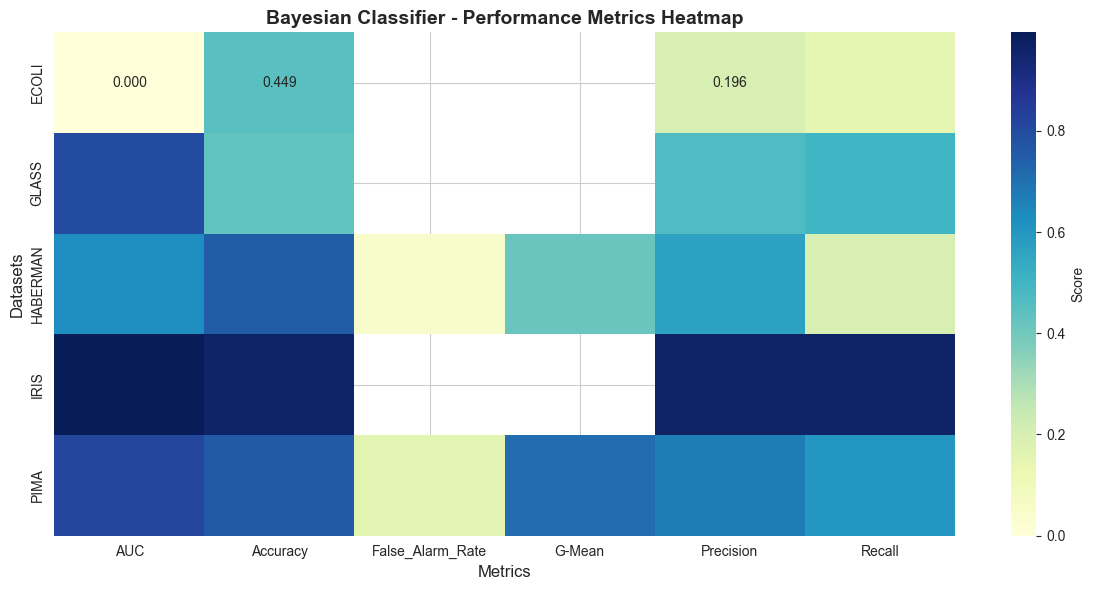

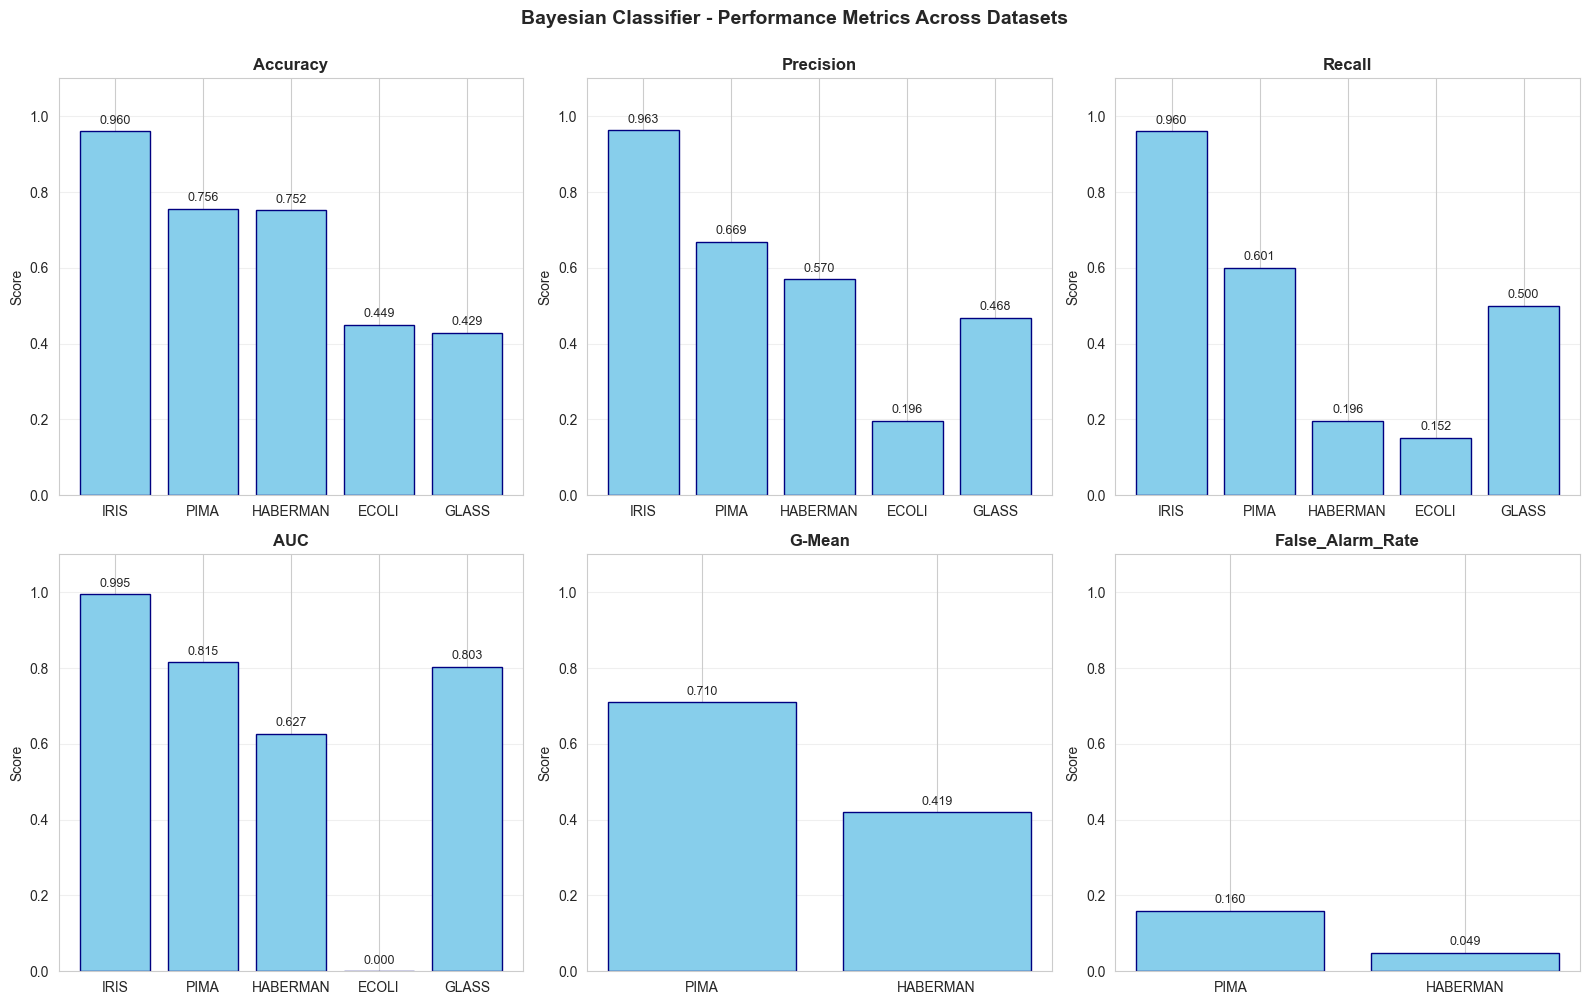

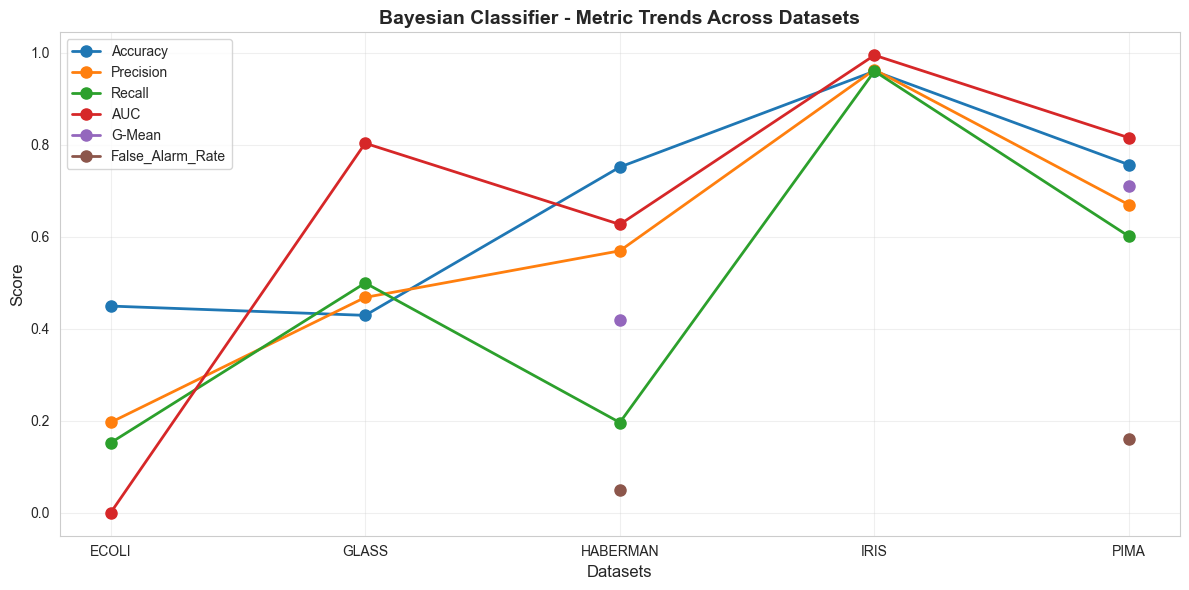


VISUALIZATION SUMMARY


In [18]:
# Prepare data for visualization
metrics_list = ['Accuracy', 'Precision', 'Recall', 'AUC', 'G-Mean', 'False_Alarm_Rate']
results_for_viz = []

for dataset_name in DATASETS:
    if dataset_name in results:
        for metric in metrics_list:
            if metric in results[dataset_name]:
                results_for_viz.append({
                    'Dataset': dataset_name.upper(),
                    'Metric': metric,
                    'Value': results[dataset_name][metric]
                })

viz_df = pd.DataFrame(results_for_viz)

# Figure 1: Metrics Heatmap
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df = viz_df.pivot(index='Dataset', columns='Metric', values='Value')
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title('Bayesian Classifier - Performance Metrics Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Datasets', fontsize=12)
plt.tight_layout()
plt.show()

# Figure 2: Bar plot - Metrics comparison across datasets
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()
for idx, metric in enumerate(metrics_list):
    metric_data = viz_df[viz_df['Metric'] == metric]
    axes[idx].bar(metric_data['Dataset'], metric_data['Value'], color='skyblue', edgecolor='navy')
    axes[idx].set_title(f'{metric}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Score', fontsize=10)
    axes[idx].set_ylim([0, 1.1] if metric != 'False_Alarm_Rate' else [0, 1.1])
    axes[idx].grid(axis='y', alpha=0.3)
    for i, v in enumerate(metric_data['Value']):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.suptitle('Bayesian Classifier - Performance Metrics Across Datasets', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Figure 3: Line plot - Metric trends
fig, ax = plt.subplots(figsize=(12, 6))
for metric in metrics_list:
    metric_data = viz_df[viz_df['Metric'] == metric].sort_values('Dataset')
    ax.plot(metric_data['Dataset'], metric_data['Value'], marker='o', label=metric, linewidth=2, markersize=8)

ax.set_title('Bayesian Classifier - Metric Trends Across Datasets', fontsize=14, fontweight='bold')
ax.set_xlabel('Datasets', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("VISUALIZATION SUMMARY")
print("="*70)